# Develop ToyTrack

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd

sys.path.append(os.path.abspath(os.path.join('..')))

from src.event_generation import *


In [2]:
# Make a particle gun
gun = ParticleGun(vx = (0, 0.1), 
                  vy = (0, 0.1), 
                  pt = (10, 20), 
                  pphi = (-np.pi, np.pi),
                  dimension = 2)

In [3]:
gun

ParticleGun(dimension=2, pt=(10, 20), pphi=(-3.141592653589793, 3.141592653589793), vx=(0, 0.1), vy=(0, 0.1), vz=0.0)

In [111]:
%%time
particles = gun.generate_particles(10000)

CPU times: user 76.4 ms, sys: 561 µs, total: 77 ms
Wall time: 76.4 ms


In [83]:
particles

[Particle(vx=0.004889290848654937, vy=0.06659833121128758, vz=0, pt=15.694647795373491, pphi=-0.5063911510638395, pz=0, dimension=2, charge=1),
 Particle(vx=0.007990489858994854, vy=0.026130364394761286, vz=0, pt=19.333443992449403, pphi=-0.9811256597176201, pz=0, dimension=2, charge=1),
 Particle(vx=0.002653543537811365, vy=0.060542337970108884, vz=0, pt=15.333018804151664, pphi=1.1666329736701897, pz=0, dimension=2, charge=1),
 Particle(vx=0.09718175420599257, vy=0.09262046622956936, vz=0, pt=18.64582835881269, pphi=-1.908075760238079, pz=0, dimension=2, charge=-1),
 Particle(vx=0.06686868611718105, vy=0.09621426981531096, vz=0, pt=13.236650947198974, pphi=-1.7404982182845474, pz=0, dimension=2, charge=1),
 Particle(vx=0.06418144322660686, vy=0.012832662615462231, vz=0, pt=18.58445264761927, pphi=0.6262322566600114, pz=0, dimension=2, charge=-1),
 Particle(vx=0.09334502089601177, vy=0.0059455777292677595, vz=0, pt=10.000962542327263, pphi=0.5289303766284905, pz=0, dimension=2, charge

In [84]:
detector = Detector(dimension = 2)

In [85]:
detector.add_from_template("barrel", min_radius=0.5, max_radius=5, number_of_layers=10)

In [86]:
detector

Detector(dimension=2), layers: [{'shape': 'cylinder', 'radius': 0.5, 'length': None}, {'shape': 'cylinder', 'radius': 1.0, 'length': None}, {'shape': 'cylinder', 'radius': 1.5, 'length': None}, {'shape': 'cylinder', 'radius': 2.0, 'length': None}, {'shape': 'cylinder', 'radius': 2.5, 'length': None}, {'shape': 'cylinder', 'radius': 3.0, 'length': None}, {'shape': 'cylinder', 'radius': 3.5, 'length': None}, {'shape': 'cylinder', 'radius': 4.0, 'length': None}, {'shape': 'cylinder', 'radius': 4.5, 'length': None}, {'shape': 'cylinder', 'radius': 5.0, 'length': None}]

In [87]:
   
def find_closest_approach(vx, vy, pt, p_phi, charge):
    r = pt
    # Adjust center calculation based on charge
    x0 = vx - charge * r * np.cos(p_phi)
    y0 = vy - charge * r * np.sin(p_phi)
    
    r0_magnitude = np.sqrt(x0**2 + y0**2)
    
    lambda_ = r / r0_magnitude
    
    Px = x0 - lambda_ * x0
    Py = y0 - lambda_ * y0
    
    d0 = np.sqrt(Px**2 + Py**2)
    phi = np.arctan2(Py, Px)
    
    return d0, phi


def create_trajectory(vx, vy, pt, p_phi, delta_theta, charge, n_points=100):
    r = pt
    # Adjust center calculation based on charge
    x0 = vx - charge * r * np.cos(p_phi)
    y0 = vy - charge * r * np.sin(p_phi)
    
    # Handle negative charge by adjusting the direction of delta_theta
    if charge == 1:
        theta = np.linspace(p_phi, p_phi + delta_theta, n_points)
    else:
        theta = np.linspace(p_phi + np.pi, p_phi + np.pi - delta_theta, n_points)

    
    x = x0 + r * np.cos(theta)
    y = y0 + r * np.sin(theta)
    
    return x, y

def plot_trajectory_segment(vx, vy, pt, p_phi, delta_theta, charge, n_points=100):
    
    x, y = create_trajectory(vx, vy, pt, p_phi, delta_theta, charge, n_points)
    
    plt.plot(x, y)
    plt.scatter([vx], [vy], color='red')  # Start point
    plt.scatter([0], [0], color='black', marker='x')  # Origin
    
    plt.axis('equal')
    plt.show()

In [88]:
particle.pphi, particle.charge

(0.6922529770387409, -1)

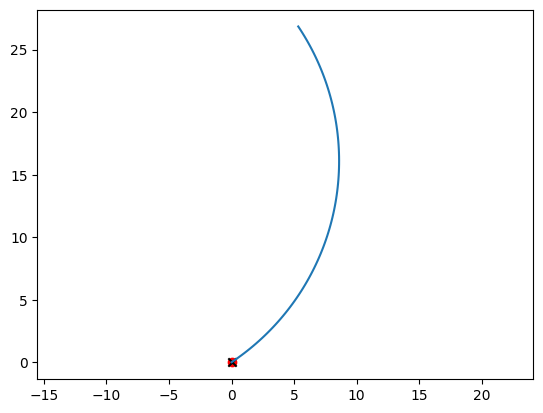

In [89]:
particle = particles[1]
plot_trajectory_segment(particle.vx, particle.vy, particle.pt, particle.pphi, np.pi/2, particle.charge)

In [90]:
def find_intersections(vx, vy, pt, p_phi, charge, r_layer):
    r = pt
    x0 = vx - charge * r * np.cos(p_phi)
    y0 = vy - charge * r * np.sin(p_phi)

    # distance between circles R
    R = np.sqrt(x0**2 + y0**2)

    a = (r**2 - r_layer**2) / (2 * R)
    b1 = np.sqrt(
        (r**2 + r_layer**2)/2 - 
        (r**2 - r_layer**2)**2 / (4 * R**2) -
        R**2 / 4
        )
    b2 = -b1

    # Calculate the intersection points
    x1 = x0/2 - a * x0/R + b1 * y0/R
    y1 = y0/2 - a * y0/R - b1 * x0/R
    x2 = x0/2 - a * x0/R + b2 * y0/R
    y2 = y0/2 - a * y0/R - b2 * x0/R

    # Check that the intersection points really are on the r_layer circle AND the particle trajectory
    if np.abs(np.sqrt(x1**2 + y1**2) - r_layer) > 1e-6:
        print('Intersection 1 is not on the circle!', np.abs(np.sqrt(x1**2 + y1**2) - r_layer))
    if np.abs(np.sqrt(x2**2 + y2**2) - r_layer) > 1e-6:
        print('Intersection 2 is not on the circle!', np.abs(np.sqrt(x2**2 + y2**2) - r_layer))
    if np.abs(np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r) > 1e-6:
        print('Intersection 1 is not on the particle trajectory!', np.abs(np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r))
    if np.abs(np.sqrt((x2 - x0)**2 + (y2 - y0)**2) - r) > 1e-6:
        print('Intersection 2 is not on the particle trajectory!', np.abs(np.sqrt((x2 - x0)**2 + (y2 - y0)**2) - r))

    return [(x1, y1), (x2, y2)]

def filter_points_on_segment(points, vx, vy, pt, p_phi, charge, delta_theta):
    valid_points = []
    r = pt
    x0 = vx - charge * r * np.cos(p_phi)
    y0 = vy - charge * r * np.sin(p_phi)
    
    for (x, y) in points:
        # Calculate the angle of the intersection point relative to the trajectory's starting point
        angle = np.arctan2(y - y0, x - x0)

        # Adjust the angle based on the charge
        if charge == -1:
            # Switch lower and upper bound
            lower_bound = p_phi + np.pi - delta_theta
            upper_bound = p_phi + np.pi

        else:
            lower_bound = p_phi
            upper_bound = p_phi + delta_theta
        
        
        # Check if the angle falls within the delta_theta range
        if (lower_bound <= angle <= upper_bound) or (lower_bound <= angle + 2*np.pi <= upper_bound):
            valid_points.append((x, y))
    
    return valid_points

radii = [layer["radius"] for layer in detector.layers]

all_intersections = []

for r_layer in radii:
    intersections = find_intersections(particle.vx, particle.vy, particle.pt, particle.pphi, particle.charge, r_layer)
    print(f'Intersections for r={r_layer:.2f}: {intersections}')
    valid_intersections = filter_points_on_segment(intersections, particle.vx, particle.vy, particle.pt, particle.pphi, particle.charge, 1)
    print(f'Valid intersections for r={r_layer:.2f}: {valid_intersections}')
    all_intersections.extend(valid_intersections)

print(all_intersections)


Intersections for r=0.50: [(0.40221830978486733, 0.2970192439452438), (-0.42857561964652097, -0.2575324023197899)]
Valid intersections for r=0.50: [(0.40221830978486733, 0.2970192439452438)]
Intersections for r=1.00: [(0.8070207997244747, 0.5905230129402916), (-0.854895812126351, -0.5187997209028126)]
Valid intersections for r=1.00: [(0.8070207997244747, 0.5905230129402916)]
Intersections for r=1.50: [(1.2041509378274975, 0.8944386613564662), (-1.2878887877964116, -0.768987951965619)]
Valid intersections for r=1.50: [(1.2041509378274975, 0.8944386613564662)]
Intersections for r=2.00: [(1.5934619817741205, 1.208668239278458), (-1.7274078043368875, -1.0079991455928943)]
Valid intersections for r=2.00: [(1.5934619817741205, 1.208668239278458)]
Intersections for r=2.50: [(1.9747569329538588, 1.5330802509166535), (-2.1732558631372974, -1.2357018059950267)]
Valid intersections for r=2.50: [(1.9747569329538588, 1.5330802509166535)]
Intersections for r=3.00: [(2.34782980624159, 1.8675372020186

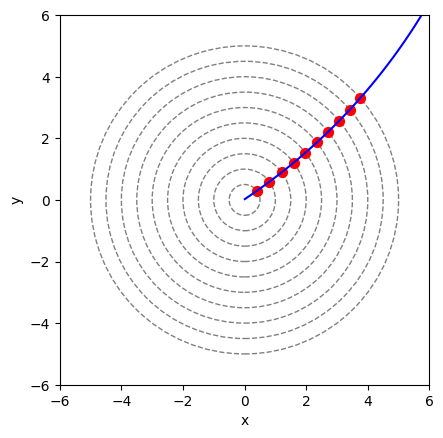

In [91]:
def plot_trajectory_with_intersections(particle, detector):
    # Create the trajectory segment
    vx, vy, pt, p_phi, charge = particle.vx, particle.vy, particle.pt, particle.pphi, particle.charge
    x, y = create_trajectory(vx, vy, pt, p_phi, np.pi/2, charge, n_points =  100)
    
    fig, ax = plt.subplots()
    ax.plot(x, y, label='Trajectory', color='blue')
    
    # # Radii for the cylindrical layers
    radii = [layer["radius"] for layer in detector.layers]
    
    # Plot each cylindrical layer and find intersections
    for r_layer in radii:
        circle = plt.Circle((0, 0), r_layer, color='gray', fill=False, linestyle='--')
        ax.add_patch(circle)
        
        intersections = find_intersections(vx, vy, pt, p_phi, charge, r_layer)
        valid_intersections = filter_points_on_segment(intersections, vx, vy, pt, p_phi, charge, np.pi/2)
        
        if valid_intersections:
            int_x, int_y = zip(*valid_intersections)
            ax.scatter(int_x, int_y, color='red', s=50, label=f'Intersections for r={r_layer:.2f}')

    max_radius = max(radii)

    ax.set_aspect('equal')
    ax.set_xlim(-max_radius-1, max_radius+1)
    ax.set_ylim(-max_radius-1, max_radius+1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

# Test the function
plot_trajectory_with_intersections(particle, detector)

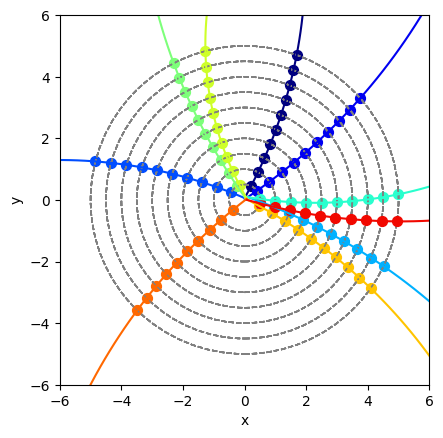

In [92]:
def plot_trajectories_with_intersections(particles, detector):
    fig, ax = plt.subplots()
    
    # Radii for the cylindrical layers
    radii = [layer["radius"] for layer in detector.layers]
    
    for i, particle in enumerate(particles):
        # Create the trajectory segment
        vx, vy, pt, p_phi, charge = particle.vx, particle.vy, particle.pt, particle.pphi, particle.charge
        x, y = create_trajectory(vx, vy, pt, p_phi, np.pi/2, charge, n_points =  100)
        
        ax.plot(x, y, label=f'Trajectory {i+1}', color=plt.cm.jet(i / len(particles)))
        
        # Plot each cylindrical layer and find intersections
        for r_layer in radii:
            circle = plt.Circle((0, 0), r_layer, color='gray', fill=False, linestyle='--')
            ax.add_patch(circle)
            
            intersections = find_intersections(vx, vy, pt, p_phi, charge, r_layer)
            valid_intersections = filter_points_on_segment(intersections, vx, vy, pt, p_phi, charge, np.pi/2)
            # valid_intersections = intersections

            if valid_intersections:
                int_x, int_y = zip(*valid_intersections)
                ax.scatter(int_x, int_y, color=plt.cm.jet(i / len(particles)), s=50, label=f'Intersections for r={r_layer:.2f}')

    max_radius = max(radii)

    ax.set_aspect('equal')
    ax.set_xlim(-max_radius-1, max_radius+1)
    ax.set_ylim(-max_radius-1, max_radius+1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

# Test the function
plot_trajectories_with_intersections(particles[:20], detector)

In [93]:
%%time
# Want to do fast calculation of particle list and layer list
# 1. Convert particle list to a pandas dataframe
particles_df = pd.DataFrame(vars(particle) for particle in particles)

CPU times: user 782 µs, sys: 0 ns, total: 782 µs
Wall time: 766 µs


In [94]:
# 2. Convert layer list to a pandas dataframe
layers_df = pd.DataFrame(layer for layer in detector.layers)

In [95]:
layers_df

,shape,radius,length
0,cylinder,0.5,None
1,cylinder,1.0,None
2,cylinder,1.5,None
3,cylinder,2.0,None
4,cylinder,2.5,None
5,cylinder,3.0,None
6,cylinder,3.5,None
7,cylinder,4.0,None
8,cylinder,4.5,None
9,cylinder,5.0,None


In [96]:
%%time
# 3. Outer merge the two dataframes
cross_joined_df = pd.merge(particles_df, layers_df, how='cross')

CPU times: user 1.13 ms, sys: 1.35 ms, total: 2.48 ms
Wall time: 2.35 ms


In [97]:
cross_joined_df

,vx,vy,pt,pphi,dimension,charge,vz,pz,d0,phi,shape,radius,length
0,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,0.5,None
1,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,1.0,None
2,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,1.5,None
3,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,2.0,None
4,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,2.5,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,cylinder,3.0,None
96,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,cylinder,3.5,None
97,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,cylinder,4.0,None
98,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,cylinder,4.5,None


In [98]:
def find_intersections_df(df):
    r = df['pt']
    x0 = df['vx'] - df['charge'] * r * np.cos(df['pphi'])
    y0 = df['vy'] - df['charge'] * r * np.sin(df['pphi'])

    # distance between circles R
    R = np.sqrt(x0**2 + y0**2)

    a = (r**2 - df['radius']**2) / (2 * R)
    b1 = np.sqrt(
        (r**2 + df['radius']**2)/2 - 
        (r**2 - df['radius']**2)**2 / (4 * R**2) -
        R**2 / 4
        )
    b2 = -b1

    # Calculate the intersection points
    x1 = x0/2 - a * x0/R + b1 * y0/R
    y1 = y0/2 - a * y0/R - b1 * x0/R
    x2 = x0/2 - a * x0/R + b2 * y0/R
    y2 = y0/2 - a * y0/R - b2 * x0/R

    df["x0"], df["y0"], df["x1"], df["y1"], df["x2"], df["y2"] = x0, y0, x1, y1, x2, y2

In [99]:
%%time
find_intersections_df(cross_joined_df)

CPU times: user 4.1 ms, sys: 122 µs, total: 4.22 ms
Wall time: 4.14 ms


In [100]:
cross_joined_df

,vx,vy,pt,pphi,dimension,charge,vz,pz,d0,phi,shape,radius,length,x0,y0,x1,y1,x2,y2
0,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,0.5,None,-13.720089,7.678887,0.212086,0.452791,-0.275034,-0.417560
1,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,1.0,None,-13.720089,7.678887,0.435228,0.900320,-0.539801,-0.841793
2,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,1.5,None,-13.720089,7.678887,0.643995,1.354722,-0.817944,-1.257366
3,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,2.0,None,-13.720089,7.678887,0.838297,1.815836,-1.109372,-1.664120
4,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,cylinder,2.5,None,-13.720089,7.678887,1.017967,2.283362,-1.413918,-2.061756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,cylinder,3.0,None,5.069265,17.497416,2.944816,-0.572762,-2.794928,1.090128
96,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,cylinder,3.5,None,5.069265,17.497416,3.443841,-0.624466,-3.244307,1.313191
97,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,cylinder,4.0,None,5.069265,17.497416,3.944766,-0.662433,-3.687950,1.548880
98,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,cylinder,4.5,None,5.069265,17.497416,4.447314,-0.686582,-4.125577,1.797113


In [101]:
def filter_points_on_segment(points, vx, vy, pt, p_phi, charge, delta_theta):
    valid_points = []
    r = pt
    x0 = vx - charge * r * np.cos(p_phi)
    y0 = vy - charge * r * np.sin(p_phi)
    
    for (x, y) in points:
        # Calculate the angle of the intersection point relative to the trajectory's starting point
        angle = np.arctan2(y - y0, x - x0)

        # Adjust the angle based on the charge
        if charge == -1:
            # Switch lower and upper bound
            lower_bound = p_phi + np.pi - delta_theta
            upper_bound = p_phi + np.pi

        else:
            lower_bound = p_phi
            upper_bound = p_phi + delta_theta
        
        
        # Check if the angle falls within the delta_theta range
        if (lower_bound <= angle <= upper_bound) or (lower_bound <= angle + 2*np.pi <= upper_bound):
            valid_points.append((x, y))
    
    return valid_points

def filter_points_on_segment_df(df):
    """
    A vectorized version of the above loop. Takes a list of 
    (x1, y1), (x2, y2) and creates two new columns, with a
    true or false entry for each point.
    """
    
    # Calculate the angle of the intersection point relative to the trajectory's starting point
    angle1 = np.arctan2(df['y1'] - df['y0'], df['x1'] - df['x0'])
    angle2 = np.arctan2(df['y2'] - df['y0'], df['x2'] - df['x0'])

    # Adjust the angle based on the charge
    lower_bound = np.where(df['charge'] == -1, df['pphi'] + np.pi - np.pi/2, df['pphi'])
    upper_bound = np.where(df['charge'] == -1, df['pphi'] + np.pi, df['pphi'] + np.pi/2)

    # Check if the angle falls within the delta_theta range
    df['valid1'] = ((lower_bound <= angle1) & (angle1 <= upper_bound)) | ((lower_bound <= angle1 + 2*np.pi) & (angle1 + 2*np.pi <= upper_bound))
    df['valid2'] = ((lower_bound <= angle2) & (angle2 <= upper_bound)) | ((lower_bound <= angle2 + 2*np.pi) & (angle2 + 2*np.pi <= upper_bound))

    return df


In [102]:
filtered_df = filter_points_on_segment_df(cross_joined_df)

In [103]:
filtered_df

,vx,vy,pt,pphi,dimension,charge,vz,pz,d0,phi,...,radius,length,x0,y0,x1,y1,x2,y2,valid1,valid2
0,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,...,0.5,None,-13.720089,7.678887,0.212086,0.452791,-0.275034,-0.417560,True,False
1,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,...,1.0,None,-13.720089,7.678887,0.435228,0.900320,-0.539801,-0.841793,True,False
2,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,...,1.5,None,-13.720089,7.678887,0.643995,1.354722,-0.817944,-1.257366,True,False
3,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,...,2.0,None,-13.720089,7.678887,0.838297,1.815836,-1.109372,-1.664120,True,False
4,0.004889,0.066598,15.694648,-0.506391,2,1,0,0,0.046240,2.051359,...,2.5,None,-13.720089,7.678887,1.017967,2.283362,-1.413918,-2.061756,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,...,3.0,None,5.069265,17.497416,2.944816,-0.572762,-2.794928,1.090128,True,False
96,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,...,3.5,None,5.069265,17.497416,3.443841,-0.624466,-3.244307,1.313191,True,False
97,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,...,4.0,None,5.069265,17.497416,3.944766,-0.662433,-3.687950,1.548880,True,False
98,0.068735,0.003437,18.194632,-1.849215,2,1,0,0,0.046018,0.591199,...,4.5,None,5.069265,17.497416,4.447314,-0.686582,-4.125577,1.797113,True,False


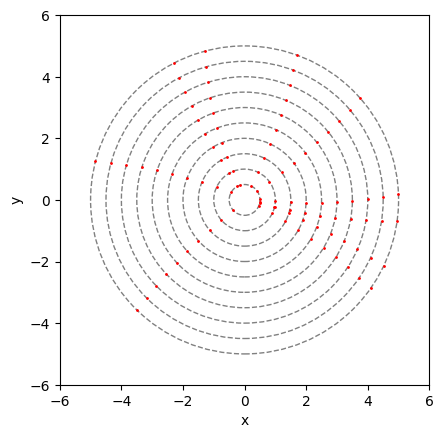

In [104]:
def plot_hit_df(df):
    fig, ax = plt.subplots()
    
    # Radii for the cylindrical layers
    radii = [layer for layer in detector.layers]

    # Plot each cylindrical layer
    for layer in radii:
        circle = plt.Circle((0, 0), layer["radius"], color='gray', fill=False, linestyle='--')
        ax.add_patch(circle)

    # Plot the hits
    hits = pd.concat([df[df['valid1'] == True][['x1', 'y1']].rename(columns={'x1': 'x', 'y1': 'y'}), 
                        df[df['valid2'] == True][['x2', 'y2']].rename(columns={'x2': 'x', 'y2': 'y'})])
    ax.scatter(hits['x'], hits['y'], color='red', s=1, label=f'Hits')

    max_radius = max([layer["radius"] for layer in detector.layers])

    ax.set_aspect('equal')
    ax.set_xlim(-max_radius-1, max_radius+1)
    ax.set_ylim(-max_radius-1, max_radius+1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

plot_hit_df(filtered_df)

    


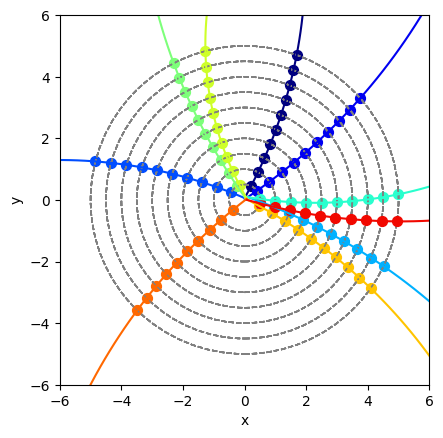

In [105]:
plot_trajectories_with_intersections(particles[:20], detector)

## Timing Studies

In [112]:
from time import time
# Run timing tests for all above steps
# 1. Generate particles

number_trials = 10
tic = time()
for i in range(number_trials):
    particles = gun.generate_particles(10000)

print(f'Particle generation took {(time() - tic) / number_trials:.2f} seconds')

# 2. Convert particle list to a pandas dataframe
tic = time()
for i in range(number_trials):
    particles_df = pd.DataFrame(vars(particle) for particle in particles)

print(f'Particle dataframe conversion took {(time() - tic) / number_trials:.2f} seconds')

# 3. Convert layer list to a pandas dataframe
tic = time()
for i in range(number_trials):
    layers_df = pd.DataFrame(layer for layer in detector.layers)

print(f'Layer dataframe conversion took {(time() - tic) / number_trials:.2f} seconds')

# 4. Outer merge the two dataframes
tic = time()
for i in range(number_trials):
    cross_joined_df = pd.merge(particles_df, layers_df, how='cross')

print(f'Outer merge took {(time() - tic) / number_trials:.2f} seconds')

# 5. Find intersections
tic = time()
for i in range(number_trials):
    find_intersections_df(cross_joined_df)

print(f'Intersection calculation took {(time() - tic) / number_trials:.2f} seconds')

# 6. Filter points on segment
tic = time()
for i in range(number_trials):
    filter_points_on_segment_df(cross_joined_df)

print(f'Filtering points on segment took {(time() - tic) / number_trials:.2f} seconds')


Particle generation took 0.09 seconds
Particle dataframe conversion took 0.03 seconds
Layer dataframe conversion took 0.00 seconds
Outer merge took 0.01 seconds
Intersection calculation took 0.01 seconds
Filtering points on segment took 0.01 seconds


In [144]:
# Run all steps above within a loop
number_trials = 10
tic = time()
for i in range(number_trials):
    particles = gun.generate_particles(10000)
    particles_df = pd.DataFrame(vars(particle) for particle in particles)
    layers_df = pd.DataFrame(layer for layer in detector.layers)
    cross_joined_df = pd.merge(particles_df, layers_df, how='cross')
    find_intersections_df(cross_joined_df)
    filtered_df = filter_points_on_segment_df(cross_joined_df)

print(f'All steps took {(time() - tic) / number_trials:.4f} seconds')

All steps took 0.1501 seconds


In [116]:
def generate_particles_and_hits(gun, detector, number_of_particles):
    particles = gun.generate_particles(number_of_particles)
    particles_df = pd.DataFrame(vars(particle) for particle in particles)
    layers_df = pd.DataFrame(layer for layer in detector.layers)
    cross_joined_df = pd.merge(particles_df, layers_df, how='cross')
    find_intersections_df(cross_joined_df)
    filtered_df = filter_points_on_segment_df(cross_joined_df)
    return filtered_df

In [146]:
# Run all steps above within a loop
number_trials = 10
tic = time()
for i in range(number_trials):
    filtered_df = generate_particles_and_hits(gun, detector, 10000)

print(f'All steps took {(time() - tic) / number_trials:.4f} seconds')

All steps took 0.1557 seconds


In [148]:
# Run a scaling study across number_of_particles, and plot the timing behavior

number_of_particles = np.logspace(0, 4.5, 20, dtype=int)
number_trials = 30

timing_results = []

for n in number_of_particles:
    for i in range(number_trials):
        tic = time()
        generate_particles_and_hits(gun, detector, n)
        timing_results.append((n, (time() - tic)))
    print(f'Finished {n} particles')

# Convert the results to a dataframe
timing_df = pd.DataFrame(timing_results, columns=['number_of_particles', 'time'])

Finished 1 particles
Finished 1 particles
Finished 2 particles
Finished 5 particles
Finished 8 particles
Finished 15 particles
Finished 26 particles
Finished 45 particles
Finished 78 particles
Finished 135 particles
Finished 233 particles
Finished 402 particles
Finished 695 particles
Finished 1199 particles
Finished 2069 particles
Finished 3569 particles
Finished 6158 particles
Finished 10624 particles
Finished 18329 particles
Finished 31622 particles


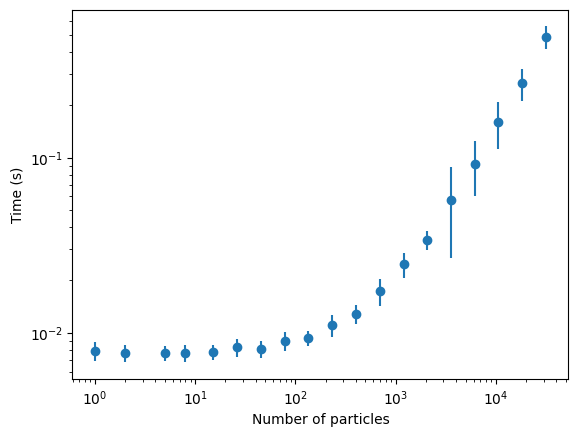

In [149]:
# Plot the results, as mean and std for each number of particles
x = timing_df.groupby('number_of_particles').mean().index
y = timing_df.groupby('number_of_particles').mean()['time']
y_err = timing_df.groupby('number_of_particles').std()['time']

plt.errorbar(x, y, yerr=y_err, fmt='o')
plt.xlabel('Number of particles')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.show()

# Test ToyTrack from local

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np

sys.path.append("../../../ExaLibraries/")

from ToyTrack.toytrack import ParticleGun, Detector, EventGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# Initialize a particle gun which samples uniformly from pt between 10 and 20 GeV, 
# initial direction phi between -pi and pi, and creation vertex vx and vy between -0.1 and 0.1 cm
particle_gun = ParticleGun(dimension=2, pt=(2, 20), pphi=(-np.pi, np.pi), vx=(-0.1, 0.1), vy=(-0.1, 0.1))

# Initialize a detector
detector = Detector(dimension=2)
detector.add_from_template('barrel', min_radius=0.5, max_radius=3, number_of_layers=10)

# Initialize an event generator
event = EventGenerator(particle_gun, detector, num_particles=(50, 5, 'normal')).generate_event()

# Access the particles and hits as needed
particles = event.particles
hits = event.hits

In [57]:
detector

Detector(dimension=2), layers: [{'shape': 'cylinder', 'radius': 0.5, 'length': None}, {'shape': 'cylinder', 'radius': 0.7777777777777778, 'length': None}, {'shape': 'cylinder', 'radius': 1.0555555555555556, 'length': None}, {'shape': 'cylinder', 'radius': 1.3333333333333335, 'length': None}, {'shape': 'cylinder', 'radius': 1.6111111111111112, 'length': None}, {'shape': 'cylinder', 'radius': 1.8888888888888888, 'length': None}, {'shape': 'cylinder', 'radius': 2.166666666666667, 'length': None}, {'shape': 'cylinder', 'radius': 2.4444444444444446, 'length': None}, {'shape': 'cylinder', 'radius': 2.7222222222222223, 'length': None}, {'shape': 'cylinder', 'radius': 3.0, 'length': None}]

In [58]:
hits

,x,y,particle_id
0,-0.287028,0.409408,0
1,-0.470405,0.619401,0
2,-0.656998,0.826166,0
3,-0.846904,1.029821,0
4,-1.040128,1.230371,0
...,...,...,...
445,-1.260534,-1.406753,44
446,-1.507239,-1.556494,44
447,-1.764734,-1.691456,44
448,-2.032529,-1.810889,44


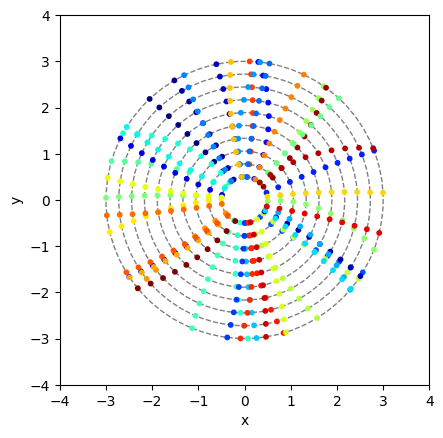

In [62]:
event.display()

# Test ToyTrack from pip

In [1]:
import sys
sys.path.append("../../../ExaLibraries/")
from ToyTrack.toytrack import ParticleGun, Detector, EventGenerator

In [8]:
# from toytrack import ParticleGun, Detector, EventGenerator
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Initialize a particle gun which samples uniformly from pt between 10 and 20 GeV, 
# initial direction phi between -pi and pi, and creation vertex vx and vy between -0.1 and 0.1 cm
particle_gun = ParticleGun(dimension=2, pt=(2, 20), pphi=(-np.pi, np.pi), vx=(-0.1, 0.1), vy=(-0.1, 0.1))

# Initialize a detector
detector = Detector(dimension=2).add_from_template('barrel', min_radius=0.5, max_radius=3, number_of_layers=10)

# Initialize an event generator
event = EventGenerator(particle_gun, detector, num_particles=(30, 5, 'normal')).generate_event()

# Access the particles and hits as needed
particles = event.particles
hits = event.hits

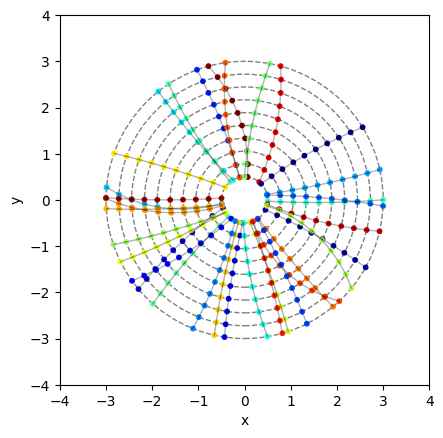

In [4]:
event.display()

In [10]:
# Run above timing study, with pip installed library
number_of_particles = np.logspace(0, 4.5, 20, dtype=int)
number_trials = 30

timing_results = []

for n in number_of_particles:
    for i in range(number_trials):
        tic = time()
        event = EventGenerator(particle_gun, detector, num_particles=int(n)).generate_event()
        timing_results.append((n, (time() - tic)))
    print(f'Finished {n} particles')


Finished 1 particles
Finished 1 particles
Finished 2 particles
Finished 5 particles
Finished 8 particles
Finished 15 particles
Finished 26 particles
Finished 45 particles
Finished 78 particles
Finished 135 particles
Finished 233 particles
Finished 402 particles
Finished 695 particles
Finished 1199 particles
Finished 2069 particles
Finished 3569 particles
Finished 6158 particles
Finished 10624 particles
Finished 18329 particles
Finished 31622 particles


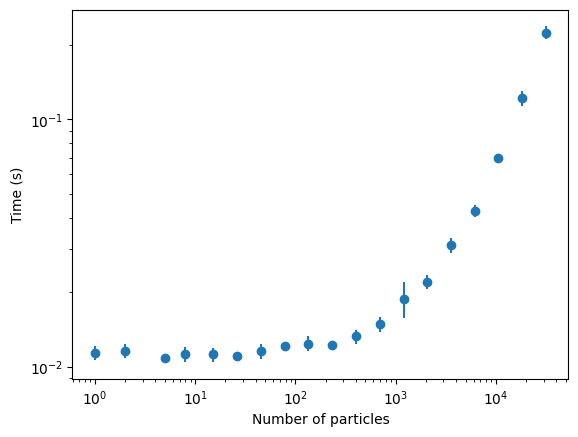

In [11]:
# Convert the results to a dataframe
timing_df = pd.DataFrame(timing_results, columns=['number_of_particles', 'time'])

# Plot the results, as mean and std for each number of particles
x = timing_df.groupby('number_of_particles').mean().index
y = timing_df.groupby('number_of_particles').mean()['time']
y_err = timing_df.groupby('number_of_particles').std()['time']

plt.errorbar(x, y, yerr=y_err, fmt='o')
plt.xlabel('Number of particles')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.show()